In [1]:
import distribution_modules as dm
import density_estimation_modules as dem
import classification_modules as cm
import exploration_modules as expo
import importlib

importlib.reload(dm)
importlib.reload(dem)
importlib.reload(cm)
importlib.reload(expo)

<module 'exploration_modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\exploration_modules.py'>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set configuration
sample_size, nr_sample_sets, nr_moments = 100, 30, 10
n_folds = 5
test_size = 0.2

## Bounded distributions

### same number of elements

In [5]:
bounded_dists = dm.get_bounded_distribution()
bounded_samples = dm.get_st_samples(bounded_dists, nr_sample_sets, sample_size)
#dm.plot_histograms_of_samples(bounded_samples)

In [6]:
moments_df = dem.get_moments(bounded_samples, nr_moments)
moments_df.head(3)

,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,label
0,-4.529710e-16,1.0,0.636734,2.554993,3.843770,10.073904,20.286472,48.233323,107.244747,251.173206,beta_1_2
1,3.552714e-17,1.0,0.465976,1.967524,2.087046,5.472897,8.307781,18.437831,32.923056,68.973542,beta_1_2
2,1.931788e-16,1.0,0.876111,3.198683,6.200661,17.792363,45.221482,127.842481,356.562823,1027.913827,beta_1_2


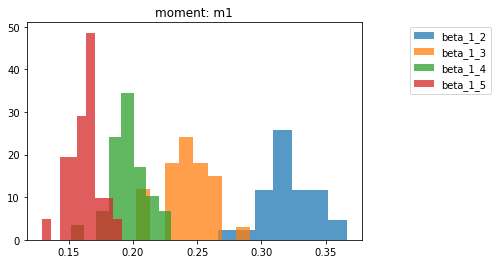

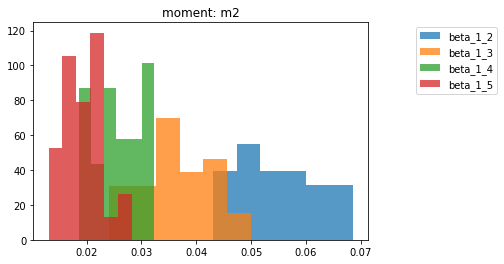

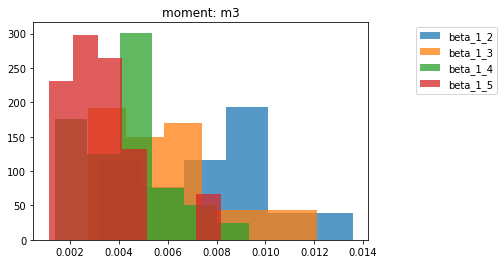

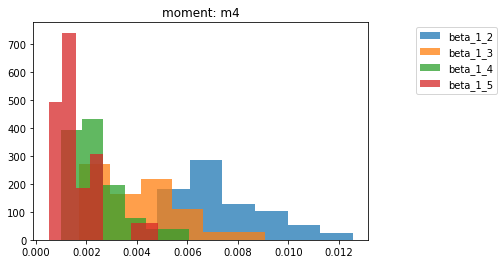

In [51]:
dem.get_histogram_of_moments(moments_df)

#### SVM

In [40]:
sample_size_list = [5, 10, 50, 100, 500, 1000]
nr_moments_list = np.arange(2,21)

##### version 1

In [12]:
res_svm = cm.cv_samplesize_moments(sample_size_list, nr_moments_list, bounded_dists, nr_sample_sets, n_folds, test_size, 1)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

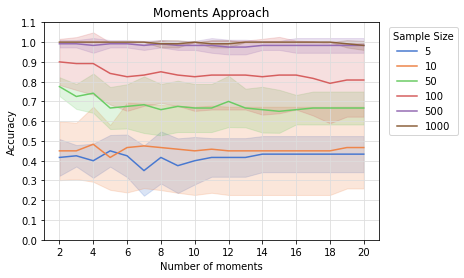

In [13]:
cm.plot_cv_moments(res_svm)

##### version 2

In [166]:
cost = [0.01, 0.25, 1, 5, 10]
gamma = [0.01, 0.25, 1, 5, 10]

In [167]:
res_svm_v2 = cm.cv_samplesize_moments_svm(sample_size_list, nr_moments_list, bounded_dists, nr_sample_sets, n_folds, test_size, cost, gamma)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

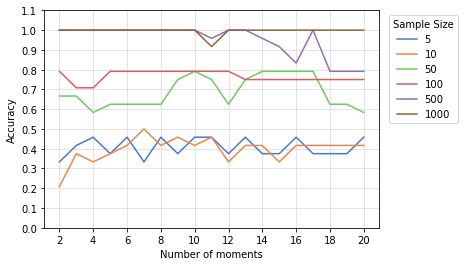

In [168]:
cm.plot_cv_moments_v2(res_svm_v2)

In [97]:
res_svm.to_csv('results/moments/res_svm_bounded.csv')
res_svm_v2.to_csv('results/moments/res_svm_bounded_v2.csv')

#### Logistic Regression

##### version 1

In [26]:
res_lr = cm.cv_samplesize_moments(sample_size_list, nr_moments_list, bounded_dists, nr_sample_sets, n_folds, test_size, 2)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

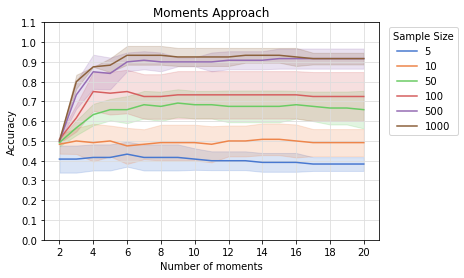

In [27]:
cm.plot_cv_moments(res_lr)

##### version 2

In [169]:
C = [0.01, 0.25, 1, 5, 10]

In [175]:
res_lr_v2 = cm.cv_samplesize_moments_lr(sample_size_list, nr_moments_list, bounded_dists, nr_sample_sets, n_folds, test_size, C)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

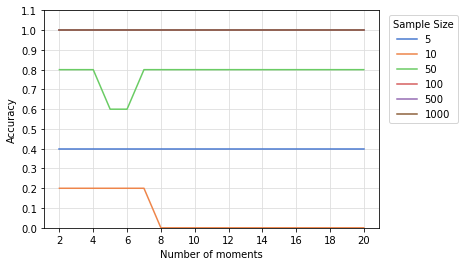

In [177]:
cm.plot_cv_moments_v2(res_lr_v2)

In [41]:
res_lr.to_csv('results/moments/res_lr_bounded.csv')

### Varying number of elements

#### SVM

In [30]:
res_svm_flex = cm.cv_samplesize_moments_flex(sample_size_list, nr_moments_list, bounded_dists, nr_sample_sets, n_folds, test_size, 1)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

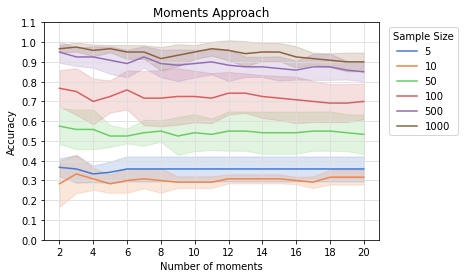

In [31]:
cm.plot_cv_moments(res_svm_flex)

#### Logistic regression

In [58]:
res_svm_flex_lr = cm.cv_samplesize_moments_flex(sample_size_list, nr_moments_list, bounded_dists, nr_sample_sets, n_folds, test_size, 2)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

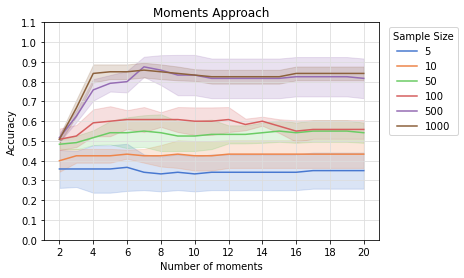

In [59]:
cm.plot_cv_moments(res_svm_flex_lr)

### Heavytail distributions

In [55]:
heavytail_dists = dm.get_heavytail_distribution()
heavytail_samples = dm.get_samples(heavytail_dists, nr_sample_sets, sample_size, transform = True)
#dm.plot_histograms_of_samples(heavytail_samples)

In [57]:
nr_moments=10
moments_df = dem.get_moments(heavytail_samples, nr_moments)
moments_df.head(3)

,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,label
0,0.856877,0.552635,0.748622,2.125040,5.403208,15.071385,42.571253,122.847375,358.836857,1059.227915,cauchy
1,0.751252,0.339962,0.267032,0.698255,1.472459,3.699299,9.373294,24.346420,63.687560,167.447454,cauchy
2,0.961129,0.651867,0.673340,1.947710,4.503151,12.425193,34.745404,101.215808,300.172198,903.644430,cauchy


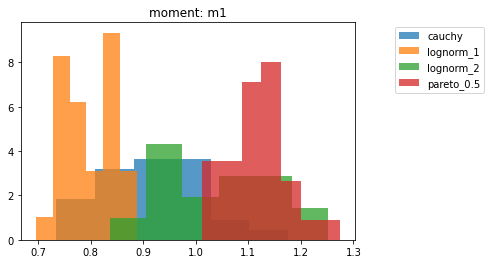

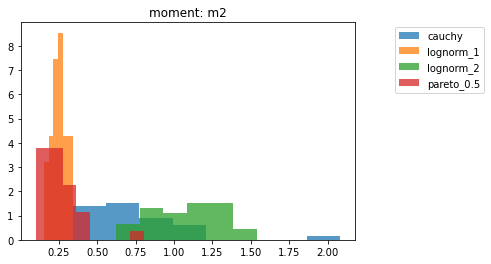

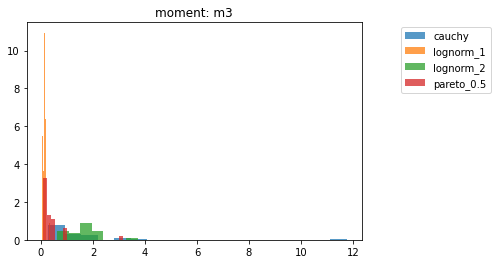

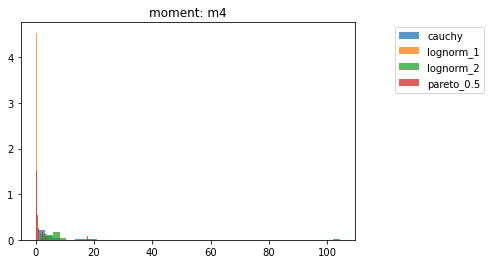

In [206]:
dem.get_histogram_of_moments(moments_df)

#### SVM

In [36]:
res_svm_ht = cm.cv_samplesize_moments(sample_size_list, nr_moments_list, heavytail_dists, nr_sample_sets, n_folds, test_size, 1, transform = True)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

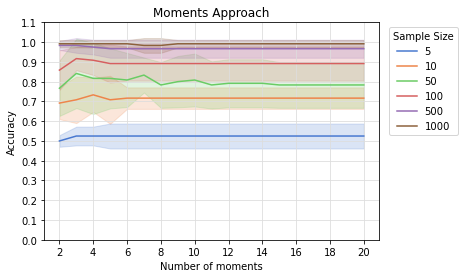

In [37]:
cm.plot_cv_moments(res_svm_ht)

#### Logistic Regression

In [60]:
res_lr_ht = cm.cv_samplesize_moments(sample_size_list, nr_moments_list, heavytail_dists, nr_sample_sets, n_folds, test_size, 2, transform=True)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

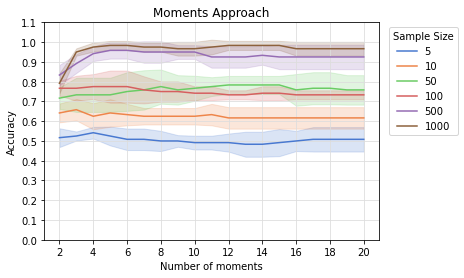

In [61]:
cm.plot_cv_moments(res_lr_ht)

In [45]:
res_svm_ht.to_csv('results/moments/res_svm_heavytail.csv')
res_lr_ht.to_csv('results/moments/res_lr_heavytail.csv')

### Multi-modal

In [7]:
nr_modes = 5
nr_sample_sets = 20
nr_mm_dist = 10
sample_size=50

In [9]:
mm_df= dm.get_multimodal_dists(nr_mm_dist, nr_sample_sets, nr_modes, sample_size)
moments_df = dem.get_moments(mm_df, 10)
moments_df.head(30)

,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,label
0,6.388720,5.752203,-10.026001,85.026482,-330.315945,1993.160580,-9976.745486,56266.807504,-303483.740147,1.690729e+06,Dist 1
1,6.323754,6.052269,-8.666667,80.900174,-284.142378,1751.166466,-8341.362948,46674.262523,-243641.253847,1.332347e+06,Dist 1
2,6.304818,5.357178,-7.512163,70.187785,-232.262796,1430.194929,-6445.984908,35704.428301,-179267.275802,9.657506e+05,Dist 1
3,6.289307,6.161980,-5.934494,80.605269,-219.085371,1608.336318,-6519.930701,39482.263051,-186353.388458,1.050652e+06,Dist 1
4,6.336300,5.622297,-7.248491,70.568597,-228.351337,1376.377843,-6177.040631,33471.323707,-168220.491960,8.960496e+05,Dist 1
5,6.242297,5.991998,-9.097600,88.690026,-319.041798,1997.657089,-9489.737093,53228.928701,-275822.459649,1.503508e+06,Dist 1
6,6.241684,5.983795,-7.999998,86.403865,-297.139201,2007.397365,-9805.454529,59262.774099,-327638.230827,1.938372e+06,Dist 1
7,6.270299,4.970867,-6.587393,64.255848,-221.645186,1349.538936,-6279.162611,34285.215182,-174097.259066,9.257757e+05,Dist 1
8,6.384658,5.726093,-7.624639,78.201476,-272.480275,1718.214696,-8230.624933,46492.839473,-245159.074363,1.353199e+06,Dist 1
9,6.312526,5.827462,-7.444551,79.298957,-265.550899,1695.343261,-7895.611414,44489.880847,-229520.226085,1.252612e+06,Dist 1


In [64]:
mm_df= dm.get_multimodal_dists(nr_mm_dist, nr_sample_sets, nr_modes, sample_size)
moments_df = dem.get_moments(mm_df, 10)
moments_df.head(30)

,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,label
0,5.642819,4.399178,1.487521,34.496045,23.338329,340.278178,366.134052,3853.484058,5580.122282,4.753285e+04,Dist 1
1,5.806675,5.106193,-1.025746,54.337707,-65.559891,802.545709,-1903.150686,14432.223537,-47600.088573,2.901972e+05,Dist 1
2,5.858496,5.185841,-0.978136,55.520206,-67.953094,862.177223,-2126.272317,16611.611022,-57243.435095,3.585119e+05,Dist 1
3,5.825449,4.784361,0.159420,52.988503,-35.238246,913.520486,-1579.418881,19891.473686,-55094.472904,4.889728e+05,Dist 1
4,5.911484,4.854418,-2.159519,57.448613,-136.094616,1145.631465,-4647.984809,29130.665378,-142496.640012,8.138861e+05,Dist 1
5,5.778915,4.473934,-0.701671,44.067205,-52.632670,645.342360,-1553.657519,11643.011905,-38715.035203,2.322787e+05,Dist 1
6,5.918873,4.897544,-0.290938,51.246416,-56.708291,819.095425,-1965.721446,16225.710811,-54737.390876,3.539534e+05,Dist 1
7,5.800891,5.173967,-1.185425,61.543156,-87.005372,1109.619154,-3025.741060,24779.970515,-92371.269131,6.176991e+05,Dist 1
8,5.744857,5.382830,-0.106358,58.578907,-36.317260,844.474252,-1219.350609,14232.013495,-32140.063542,2.628900e+05,Dist 1
9,5.788458,5.250732,0.749502,51.731904,-11.069535,674.040369,-587.567150,10535.078068,-17596.459119,1.859436e+05,Dist 1


#### SVM

In [73]:
res_svm_mm = cm.cv_samplesize_moments_mm(sample_size_list, nr_moments_list, nr_sample_sets, nr_mm_dist, nr_modes, n_folds, test_size, 1)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

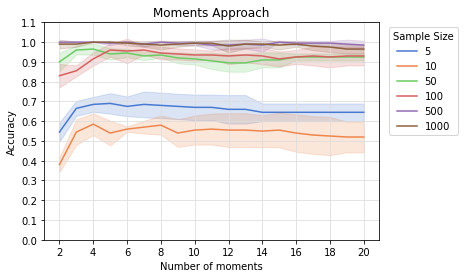

In [74]:
cm.plot_cv_moments(res_svm_mm)

#### Logistic Regression

In [70]:
res_lr_mm = cm.cv_samplesize_moments_mm(sample_size_list, nr_moments_list, bounded_dists, nr_sample_sets, n_folds, test_size, 2)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

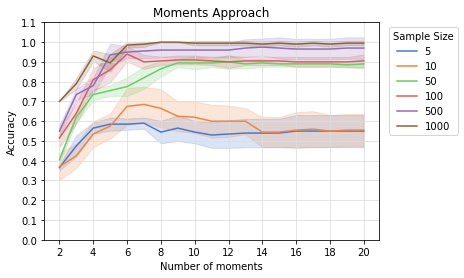

In [71]:
cm.plot_cv_moments(res_lr_mm)

In [90]:
cost = [0.01, 0.1, 0.25, 1, 5, 10]
gamma = [0.01, 0.1, 0.25, 1, 5, 10]
c = [0.01, 0.1, 0.25, 1, 5, 10]
result

,fold,cost,gamma,loss
0,0,0.01,0.01,65.105326
1,1,0.01,0.01,62.361650
2,2,0.01,0.01,87.416712
3,3,0.01,0.01,59.424201
4,4,0.01,0.01,87.442728
...,...,...,...,...
175,0,10.00,10.00,0.000000
176,1,10.00,10.00,0.000000
177,2,10.00,10.00,0.000000
178,3,10.00,10.00,0.000000


In [94]:
#grid search svm
result = cm.grid_search_lr(moments_df, 5,c)
result
#ax = sns.lineplot(data=result, x=result['cost'], y=result['loss'], hue=result['gamma'], ci='sd', palette='muted')

0.1